In [2]:
import pandas as pd
import json
import numpy as np
import os
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import math
import scipy

In [3]:
f1 = open('historic_data/historic1.json')
data1 = json.load(f1)

f2 = open('historic_data/historic2.json')
data2 = json.load(f2)

#delete 0s
data1.pop(0)
data1.pop(0)

ask_prices = [data1[tick][0]["ask_prices"] for (tick, val) in enumerate(data1)]
bid_prices = [data1[tick][0]["bid_prices"] for (tick, val) in enumerate(data1)]
ask_volumes = [data1[tick][0]["ask_volumes"] for (tick, val) in enumerate(data1)]
bid_volumes = [data1[tick][0]["bid_volumes"] for (tick, val) in enumerate(data1)]

# STUFF

In [4]:
'''
GUYS FORGET ABOUT THE STUFF BELOW THIS CELL
THIS IS THE ONE
'''
ask_prices_df = pd.DataFrame(ask_prices).T
bid_prices_df = pd.DataFrame(bid_prices).T
ask_volumes_df = pd.DataFrame(ask_volumes).T
bid_volumes_df = pd.DataFrame(bid_volumes).T


ask_prices_liq = ask_prices_df*ask_volumes_df/ask_volumes_df.sum()
bid_prices_liq = bid_prices_df*bid_volumes_df/bid_volumes_df.sum()

# expected value wrt liquidity
ev_ask = ask_prices_liq.sum()
ev_bid = bid_prices_liq.sum()



#compute variance wrt liquidity
mu_squared_ask = []
for i in range(len(ask_prices_df.T)):
    prices = (ask_prices_df[i].dropna())**2
    weights = ask_volumes_df[i].dropna()
    mu_squared_ask.append(np.average(prices, weights=weights))

mu_squared_ask = np.array(mu_squared_ask)
std_liq_ask = np.sqrt(mu_squared_ask - (ask_prices_liq.sum())**2)

mu_squared_bid = []
for i in range(len(bid_prices_df.T)):
    prices = (bid_prices_df[i].dropna())**2
    weights = bid_volumes_df[i].dropna()
    mu_squared_bid.append(np.average(prices, weights=weights))

mu_squared_bid = np.array(mu_squared_bid)
std_liq_bid = np.sqrt(mu_squared_bid - (bid_prices_liq.sum())**2)



In [7]:
def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

#fit_sin([i for i in range(len(ev_ask))], ev_ask)

sin_f = fit_sin([i for i in range(len(ev_ask))], ev_ask)
N, amp, omega, phase, offset = len(ev_ask), sin_f["amp"], sin_f["omega"], sin_f["phase"], sin_f["offset"]
tt = np.array([i for i in range(len(ev_ask))])
tt2 = tt*10
yy_1 = amp*np.sin(omega*tt + phase) + offset
yy_2 = []

bound_x = max(tt)
mean_t = tt.mean()
var_t = tt.var()
a_values = np.arange(0,10, 0.025)

a_exp = {value: [] for value in a_values}

for a in a_values:
    for i in range(len(tt)):
        a_exp[a].append((a*amp*np.sin((omega*i + phase)) + offset))


print( "Amplitude=%(amp)s, Angular freq.=%(omega)s, phase=%(phase)s, offset=%(offset)s, Max. Cov.=%(maxcov)s" % res)

# test for fitness
error_a = {value: 0 for value in a_values}


for i in range(len(ev_ask)):
    for k,v in a_exp.items():
        error_a[k] += abs(v[i]-ev_ask[i])/len(ev_ask)
        
errors = np.array([v for k,v in error_a.items()])
    
a_fit = a_values[errors.argmin()]
#plt.plot(tt,a_exp[0.1])

for i in range(len(tt)):
        yy_2.append((a_fit*amp*np.sin((omega*i + phase)) + offset))

plt.plot(tt,yy_2)

def get_hurst_exponent(time_series, max_lag=20):
    """Returns the Hurst Exponent of the time series"""
    
    lags = range(2, max_lag)

    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]

    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)

    return reg[0]

hurst_bid, hurst_ask = get_hurst_exponent(np.array(ev_bid)), get_hurst_exponent(np.array(ev_ask))


NameError: name 'res' is not defined

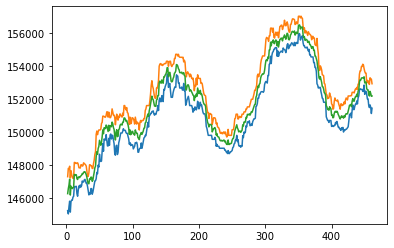

In [233]:
plt.plot(bid_prices_dataframe.mean())
plt.plot(ask_prices_dataframe.mean())
plt.plot(ask_prices_dataframe.add(bid_prices_dataframe).mean()/2)

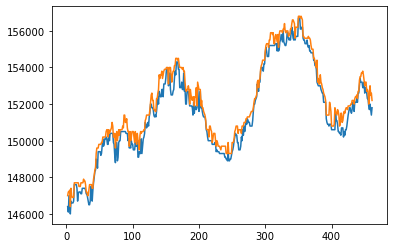

In [234]:
#spread

plt.plot(bid_prices_dataframe.max())
plt.plot(ask_prices_dataframe.min())

(460.2173913043478, 317.33496134609317)

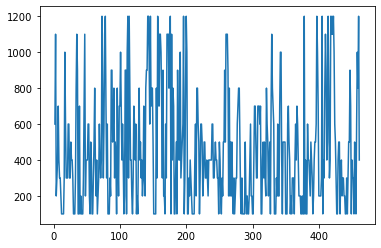

In [235]:
#spread
spread = ask_prices_dataframe.min() - bid_prices_dataframe.max()
plt.plot(spread)

spread.mean(), spread.std()

300

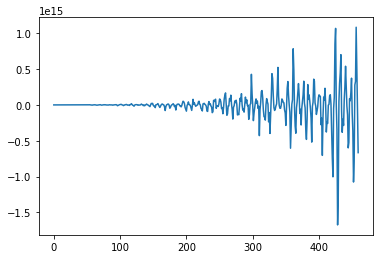

In [236]:
# model the spread with brownian motion
# we use the function 


avg_price = ask_prices_dataframe.add(bid_prices_dataframe).mean()/2

'''
if liquidity is accumulated in the end, then price stays more or less the same
if liquidity tends towards the end, expect price changes

to define metric that tells how price is distributed wrt liquidity
'''

# how is it moving
corr = ask_prices_dataframe[2].corr(ask_prices_dataframe[3],method="pearson")*bid_prices_dataframe[2].corr(bid_prices_dataframe[3],method="pearson")

# by how much on average
change = (ask_prices_dataframe + bid_prices_dataframe)/2


'''
expected price wrt liquidity
'''
mean_ask_liq = ask_prices_dataframe

def brownian(current_price,std, t):
    s_n = current_price
    return abs(s_n + float(np.random.normal(0,t* (std)**2,1)))

#def poisson()

predicted_avg_price = []

# delete nans
avg_price = np.array(avg_price)
avg_price = avg_price[~np.isnan(avg_price)]

# period of reversion to the mean
k = 1
w = 300

predicted_avg_price.append(avg_price[0])
for i in range(1, len(avg_price)):
    brown_pred = brownian(predicted_avg_price[i-1], i*avg_price.std(), i)
    predicted_avg_price.append(brown_pred* math.sin(w*i/2))


#plot
plt.plot(predicted_avg_price)


# error
#error = predicted_spread-spread
predicted_avg_price = np.array(predicted_avg_price)

predicted_avg_price.mean(), predicted_avg_price.std(), avg_price.mean(), avg_price.std()
w

In [287]:
def find_nearest(array, value):
                array = np.asarray(array)
                idx = (np.abs(array - value)).argmin()
                return idx
price_adjustment = 0.1
            
# fix a time
time = 4
mn_spread = ask_prices_liq - bid_prices_liq
askVolPriceProd = np.array([])
bidVolPriceProd = np.array([])

for it in range(len(ask_volumes)):
    np.append(askVolPriceProd,
            [ask_prices[j] for j in range(len(ask_volumes[it]))]
            )

for jit in range(len(bid_volumes)):
    np.append(bidVolPriceProd,
            [bid_prices[j] for j in range(len(bid_volumes[jit]))]
            )
askVolPriVar = askVolPriceProd.std()
bidVolPriVar = bidVolPriceProd.std()

new_bid_price = bid_prices[find_nearest(bid_prices_df[time],bid_prices_liq[time])] + price_adjustment if bid_prices[0] != 0 else 0
new_ask_price = ask_prices[find_nearest(ask_prices_df[time], ask_prices_liq[time])] + price_adjustment if ask_prices[0] != 0 else 0

new_bid_price

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().